# Denoising Models

## Imports and Definitions

In [1]:
import os
import cv2
import glob
import math
import fitz
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pytesseract as pyt

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from torch.utils.data import DataLoader

from PIL import Image, ImageOps

from diffusers import UNet2DModel, DDPMScheduler
from datasets import load_dataset, Dataset, Features, Value, Image as HfImage
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
clean = glob.glob("/teamspace/studios/this_studio/data/bronze/denoising/train/clean/*.png")
dirty = glob.glob("/teamspace/studios/this_studio/data/bronze/denoising/train/dirty/*.png")
test = glob.glob("/teamspace/studios/this_studio/data/bronze/denoising/test/*.png")

data = [
    {"image_1": c, "image_2": d} for c, d in zip(clean, dirty)
]

dataset = Dataset.from_list(data)

features = Features({
    "image_1": HfImage(),
    "image_2": HfImage()
})

dataset = dataset.cast(features)
print(dataset)

test_dataset = Dataset.from_list([{"image": c} for c in test])

features = Features({
    "image": HfImage(),
})

test_dataset = test_dataset.cast(features)
print(test_dataset)

Casting the dataset:   0%|          | 0/144 [00:00<?, ? examples/s]

Dataset({
    features: ['image_1', 'image_2'],
    num_rows: 144
})


Casting the dataset:   0%|          | 0/72 [00:00<?, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 72
})


In [3]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [4]:
def collate_train_fn(batch):
    images1 = []
    images2 = []
    for d in batch:
        img1 = transform(d['image_1'])
        img2 = transform(d['image_2'])
        images1.append(img1)
        images2.append(img2)
    return torch.stack(images1), torch.stack(images2)

def collate_test_fn(batch):
    images = []
    for d in batch:
        img = transform(d['image'])
        images.append(img)
    return torch.stack(images)

In [5]:
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_train_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_test_fn)
next(iter(train_dataloader))

(tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],
 
 
         [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9059, 0.7529],
           [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 0.9843]]],
 
 
         [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000

In [6]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if device.type == 'cuda':
            # Allow TensorFloat32 on matmul and convolutions
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
            torch.set_float32_matmul_precision("medium")
        return device

device = get_device()
device

device(type='cuda')

## Using a GAN

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0.0)

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [8]:
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [9]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [10]:
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

In [11]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [12]:
epochs = 15
lambda_pixel = 100

In [13]:
def discriminator_train_step(real_src, real_trg, fake_trg):
    #discriminator.train()
    d_optimizer.zero_grad()

    prediction_real = discriminator(real_trg, real_src)
    error_real = criterion_GAN(prediction_real, torch.ones(len(real_src), 1, 32, 32).to(device))
    error_real.backward()

    prediction_fake = discriminator(fake_trg.detach(), real_src)
    error_fake = criterion_GAN(prediction_fake, torch.zeros(len(real_src), 1, 32, 32).to(device))
    error_fake.backward()

    d_optimizer.step()

    return error_real + error_fake

def generator_train_step(real_src, fake_trg):
    #discriminator.train()
    g_optimizer.zero_grad()
    prediction = discriminator(fake_trg, real_src)

    loss_GAN = criterion_GAN(prediction, torch.ones(len(real_src), 1, 32, 32).to(device))
    loss_pixel = criterion_pixelwise(fake_trg, real_trg)
    loss_G = loss_GAN + lambda_pixel * loss_pixel

    loss_G.backward()
    g_optimizer.step()
    return loss_G

In [14]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    for batch in tqdm(train_dataloader):
        real_src, real_trg = [t.to(device) for t in batch]
        fake_trg = generator(real_src)

        errD = discriminator_train_step(real_src, real_trg, fake_trg)
        errG = generator_train_step(real_src, fake_trg)

    print(f"Epoch[{epoch+1}/{epochs}], ErrorD: {errD.item()}, ErrorG: {errG.item()}")

100%|██████████| 9/9 [00:02<00:00,  3.44it/s]


Epoch[1/15], ErrorD: 1.0841842889785767, ErrorG: 17.465099334716797


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch[2/15], ErrorD: 0.9343646764755249, ErrorG: 8.217289924621582


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch[3/15], ErrorD: 0.8828617334365845, ErrorG: 8.084404945373535


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch[4/15], ErrorD: 0.7166121602058411, ErrorG: 7.724693298339844


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch[5/15], ErrorD: 0.6804758310317993, ErrorG: 6.7810540199279785


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch[6/15], ErrorD: 0.6183111071586609, ErrorG: 7.766538619995117


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch[7/15], ErrorD: 0.6047552824020386, ErrorG: 6.355153560638428


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Epoch[8/15], ErrorD: 0.5619534254074097, ErrorG: 6.41633415222168


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch[9/15], ErrorD: 0.6165293455123901, ErrorG: 6.538749694824219


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch[10/15], ErrorD: 0.5399355888366699, ErrorG: 6.329133987426758


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch[11/15], ErrorD: 0.49826580286026, ErrorG: 5.6437883377075195


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch[12/15], ErrorD: 0.6183903217315674, ErrorG: 6.441572666168213


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch[13/15], ErrorD: 0.4735081195831299, ErrorG: 6.557727813720703


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch[14/15], ErrorD: 0.45235759019851685, ErrorG: 5.373171806335449


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

Epoch[15/15], ErrorD: 0.4671128988265991, ErrorG: 6.00229549407959


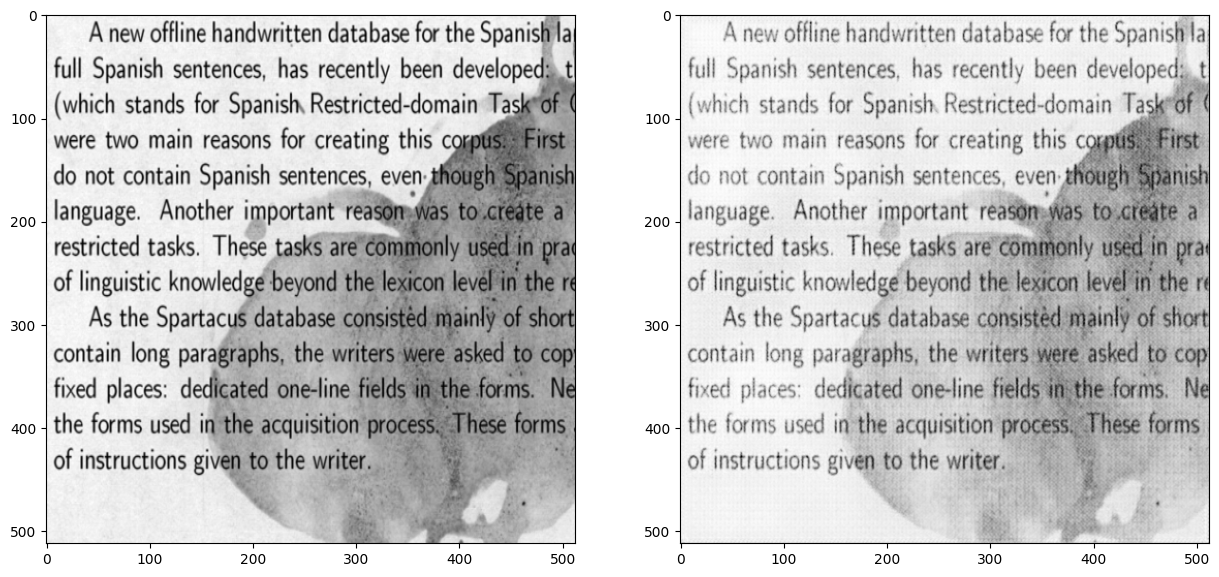

In [15]:
generator.eval()

data = next(iter(test_dataloader))
real_src = data.to(device)
fake_trg = generator(real_src)
img_sample1 = real_src[0].detach().cpu().permute(1,2,0).numpy()
img_sample2 = fake_trg[0].detach().cpu().permute(1,2,0).numpy()
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs = axs.ravel()
axs[0].imshow(img_sample1, cmap='gray')
axs[1].imshow(img_sample2, cmap='gray')
plt.show()

## Using AutoEncoder

In [16]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [17]:
def collate_train_fn(batch):
    images1 = []
    images2 = []
    for d in batch:
        img1 = transform(d['image_1'])
        img2 = transform(d['image_2'])
        images1.append(img1)
        images2.append(img2)
    return torch.stack(images1), torch.stack(images2)

def collate_test_fn(batch):
    images = []
    for d in batch:
        img = transform(d['image'])
        images.append(img)
    return torch.stack(images)

In [18]:
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_train_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_test_fn)

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder -> Downsample the image by applying convolution operations through multiple layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.GELU()
        )

        # Decoder -> Reconstruct the original image by reversing the convolution operations applied during encoding (Upsample)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1),
            nn.GELU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1),
            nn.Sigmoid() # Sigmoid operation applied for the outputs which are normalized values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
autoencoder = AutoEncoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [21]:
summary(autoencoder, input_data=torch.ones(1,1,512,512, device=device))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 512, 512]          --
├─Sequential: 1-1                        [1, 128, 64, 64]          --
│    └─Conv2d: 2-1                       [1, 32, 256, 256]         832
│    └─GELU: 2-2                         [1, 32, 256, 256]         --
│    └─Conv2d: 2-3                       [1, 64, 128, 128]         51,264
│    └─GELU: 2-4                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-5                       [1, 128, 64, 64]          204,928
│    └─GELU: 2-6                         [1, 128, 64, 64]          --
├─Sequential: 1-2                        [1, 1, 512, 512]          --
│    └─ConvTranspose2d: 2-7              [1, 64, 128, 128]         131,136
│    └─GELU: 2-8                         [1, 64, 128, 128]         --
│    └─ConvTranspose2d: 2-9              [1, 32, 256, 256]         32,800
│    └─GELU: 2-10                        [1, 32, 256, 256]        

In [22]:
epochs = 10

In [23]:
autoencoder.train()

for epoch in range(epochs):
    rmse_loss = 0.0

    for batch in tqdm(train_dataloader):
        real_src, real_trg = [t.to(device) for t in batch]

        optimizer.zero_grad()
        outputs = autoencoder(real_src)
        loss = F.mse_loss(outputs, real_trg)

        rmse = torch.sqrt(loss)
        rmse_loss += rmse.mean().item()

        loss.backward()
        optimizer.step()

    print(f"Epoch[{epoch+1}/{epochs}], mse loss: {rmse_loss/len(train_dataloader)}")

100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


Epoch[1/10], mse loss: 0.29181897309091354


100%|██████████| 9/9 [00:01<00:00,  8.87it/s]


Epoch[2/10], mse loss: 0.20753957496749031


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


Epoch[3/10], mse loss: 0.19453167253070408


100%|██████████| 9/9 [00:01<00:00,  8.89it/s]


Epoch[4/10], mse loss: 0.19280149042606354


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


Epoch[5/10], mse loss: 0.1905122829808129


100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


Epoch[6/10], mse loss: 0.18813140359189776


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


Epoch[7/10], mse loss: 0.1872803039020962


100%|██████████| 9/9 [00:01<00:00,  8.70it/s]


Epoch[8/10], mse loss: 0.18002445333533817


100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


Epoch[9/10], mse loss: 0.17616085377004412


100%|██████████| 9/9 [00:01<00:00,  8.76it/s]

Epoch[10/10], mse loss: 0.17689601911438835


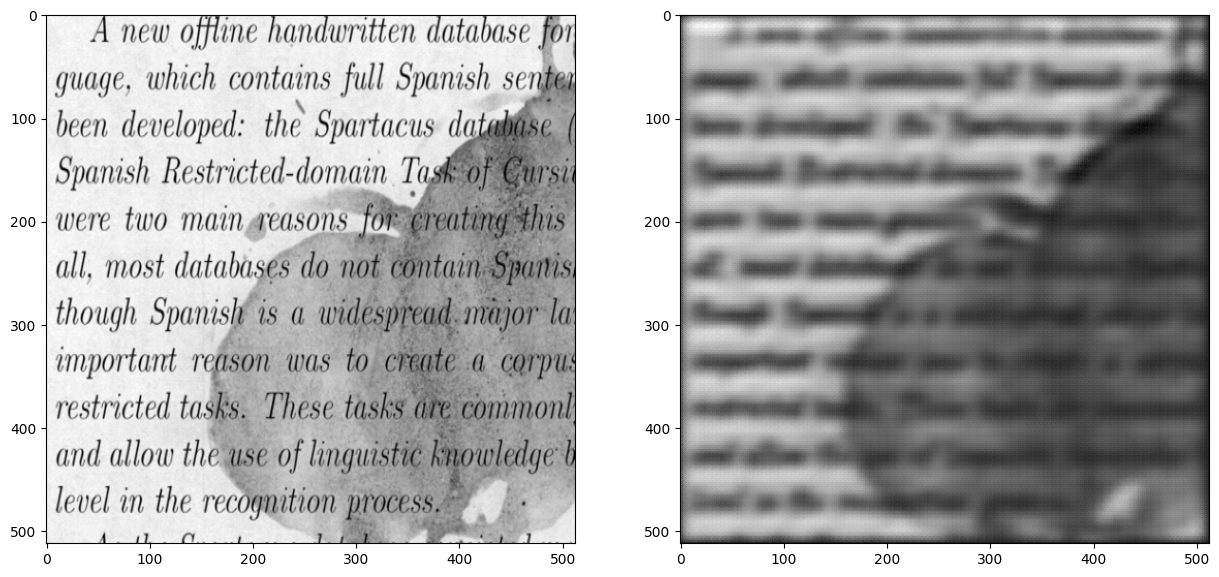

In [24]:
autoencoder.eval()

data = next(iter(test_dataloader))
real_src = data.to(device)
fake_trg = autoencoder(real_src)
img_sample1 = real_src[0].detach().cpu().permute(1,2,0).numpy()
img_sample2 = fake_trg[0].detach().cpu().permute(1,2,0).numpy()
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs = axs.ravel()
axs[0].imshow(img_sample1, cmap='gray')
axs[1].imshow(img_sample2, cmap='gray')
plt.show()

## Diffusion Model

In [35]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [36]:
def collate_train_fn(batch):
    images1 = []
    images2 = []
    for d in batch:
        img1 = transform(d['image_1'])
        img2 = transform(d['image_2'])
        images1.append(img1)
        images2.append(img2)
    return torch.stack(images1), torch.stack(images2)

def collate_test_fn(batch):
    images = []
    for d in batch:
        img = transform(d['image'])
        images.append(img)
    return torch.stack(images)

In [37]:
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_train_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_test_fn)

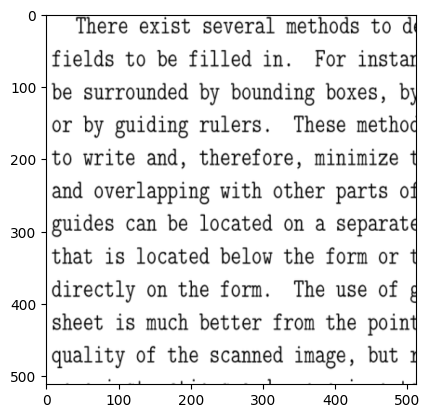

In [38]:
img1, img2 = next(iter(train_dataloader))
real_img = img1[0].cpu().permute(1,2,0).numpy()
plt.imshow(real_img, cmap='gray')

In [39]:
from diffusers import UNet2DModel, DDPMScheduler

diff = UNet2DModel(
    sample_size=512,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=(32, 32),
    down_block_types=("DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D")
).to(device)

scheduler = DDPMScheduler(num_train_timesteps=10)
optimizer = torch.optim.Adam(diff.parameters(), lr=0.00002, betas=(0.9, 0.999))

In [40]:
epochs = 15

In [41]:
diff.train()

for epoch in range(epochs):
    rmse_loss = 0.0
    
    for batch in tqdm(train_dataloader):
        clean_img, noise_img = [t.to(device) for t in batch]

        noise = torch.randn_like(noise_img)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (noise_img.shape[0],), device=device).long()
        noisy = scheduler.add_noise(noise_img, noise, timesteps)

        optimizer.zero_grad()
        pred = diff(noisy, timesteps).sample
        loss = F.mse_loss(pred, clean_img)

        loss.backward()
        optimizer.step()

        rmse = torch.sqrt(loss)
        rmse_loss += rmse.mean().item()

    print(f"Epoch[{epoch+1}/{epochs}], mse loss: {rmse_loss/len(train_dataloader)}")

100%|██████████| 9/9 [01:16<00:00,  8.48s/it]


Epoch[1/15], mse loss: 0.992166366842058


100%|██████████| 9/9 [01:16<00:00,  8.49s/it]


Epoch[2/15], mse loss: 0.9681921468840705


100%|██████████| 9/9 [01:16<00:00,  8.49s/it]


Epoch[3/15], mse loss: 0.9496110015445285


100%|██████████| 9/9 [01:16<00:00,  8.49s/it]


Epoch[4/15], mse loss: 0.9318988455666436


100%|██████████| 9/9 [01:16<00:00,  8.49s/it]


Epoch[5/15], mse loss: 0.9129460122850206


100%|██████████| 9/9 [01:16<00:00,  8.49s/it]


Epoch[6/15], mse loss: 0.8973167207505968


100%|██████████| 9/9 [01:16<00:00,  8.48s/it]


Epoch[7/15], mse loss: 0.8787289328045316


100%|██████████| 9/9 [01:16<00:00,  8.49s/it]


Epoch[8/15], mse loss: 0.8588234053717719


100%|██████████| 9/9 [01:16<00:00,  8.48s/it]


Epoch[9/15], mse loss: 0.8399571246571012


100%|██████████| 9/9 [01:16<00:00,  8.46s/it]


Epoch[10/15], mse loss: 0.8210152652528551


100%|██████████| 9/9 [01:16<00:00,  8.46s/it]


Epoch[11/15], mse loss: 0.8010581003295051


100%|██████████| 9/9 [01:16<00:00,  8.47s/it]


Epoch[12/15], mse loss: 0.7795034580760531


100%|██████████| 9/9 [01:16<00:00,  8.45s/it]


Epoch[13/15], mse loss: 0.7577853202819824


100%|██████████| 9/9 [01:16<00:00,  8.47s/it]


Epoch[14/15], mse loss: 0.7325562636057535


100%|██████████| 9/9 [01:16<00:00,  8.46s/it]

Epoch[15/15], mse loss: 0.7069388296869066


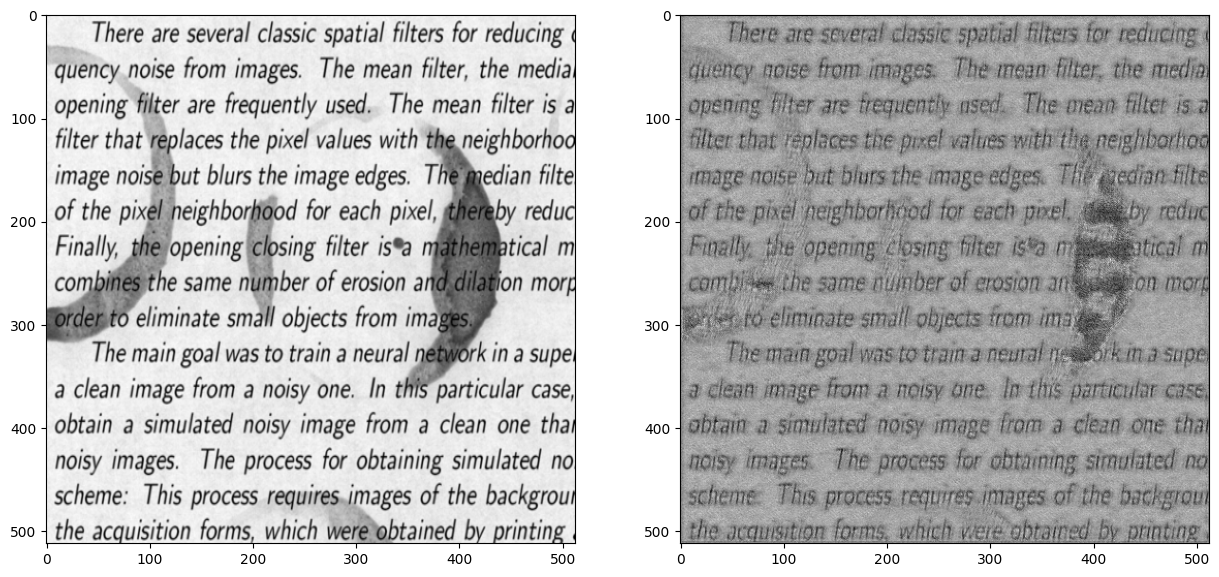

In [43]:
diff.eval()

data = next(iter(test_dataloader))
clean_img, noise_img = [t.to(device) for t in batch]
noise = torch.randn_like(noise_img)
timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (noise_img.shape[0],), device=device).long()
noisy = scheduler.add_noise(noise_img, noise, timesteps)
clean_pred = diff(noisy, timesteps).sample
img_sample1 = noise_img[0].detach().cpu().permute(1,2,0).numpy()
img_sample2 = clean_pred[0].detach().cpu().permute(1,2,0).numpy()
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs = axs.ravel()
axs[0].imshow(img_sample1, cmap='gray')
axs[1].imshow(img_sample2, cmap='gray')
plt.show()